- data 출처: https://github.com/sekilab/RoadDamageDetector?tab=readme-ov-file

In [1]:
import os
import random
import shutil
from tqdm.notebook import tqdm
import cv2
import glob
import json

In [2]:
train_path = '/Users/kimhongseok/cv_79_projects/part2/25/data/train'
valid_path = '/Users/kimhongseok/cv_79_projects/part2/25/data/valid'
test_path = '/Users/kimhongseok/cv_79_projects/part2/25/data/test'

for folder in [train_path, valid_path, test_path]:
    if not os.path.exists(folder):
        os.makedirs(folder)
    for s in ['images', 'labels']:
        s_folder = f'{folder}/{s}'
        if not os.path.exists(s_folder):
            os.makedirs(s_folder)

In [3]:
def xml_to_yolo_bbox(bbox, w, h):
    x_center = float(((bbox[2]-bbox[0])/2)/w)
    y_center = float(((bbox[3]-bbox[2])/2)/h)
    width = float((bbox[2]-bbox[0])/w)
    height = float((bbox[3]-bbox[1])/h)
    return [x_center, y_center, width, height]

In [4]:
annot_list = glob.glob(f'/Users/kimhongseok/cv_79_projects/part2/25/origin_data/train/annotations/xmls/*.xml')
print(len(annot_list))

10506


In [5]:
import xml.etree.ElementTree as ET

origin_data_path = '/Users/kimhongseok/cv_79_projects/part2/25/origin_data'
if not os.path.exists(f'{origin_data_path}/labels'):
    os.makedirs(f'{origin_data_path}/labels')

classes = []
tbar = tqdm(annot_list)
for file in tbar:
    result = [] # 현재 이미지의 bbox 정보 저장 -> 한 이미지에서 여러 bbox가 있을 수 있다.
    tree = ET.parse(file)
    root = tree.getroot()
    width = int(root.find('size').find('width').text)
    height = int(root.find('size').find('height').text)
    for obj in root.findall('object'):
        label = obj.find('name').text
        if label not in classes: # 기존에 없는 class값인 경우 추가
            classes.append(label)
        index = classes.index(label)
        pil_bbox = [int(x.text) for x in obj.find('bndbox')]
        yolo_bbox = xml_to_yolo_bbox(pil_bbox, width, height)
        bbox_string = ' '.join([str(x) for x in yolo_bbox])
        result.append(f'{index} {bbox_string}')
    if result:
        save_path = file.replace('train/annotations/xmls', 'labels').replace('xml', 'txt')
        with open(save_path, 'w', encoding='utf-8') as f:
            f.write('\n'.join(result))

  0%|          | 0/10506 [00:00<?, ?it/s]

In [6]:
print(classes)

['D50', 'D00', 'D44', 'D20', 'D10', 'D40', 'D43']


In [7]:
cls_list = classes
cls_list

['D50', 'D00', 'D44', 'D20', 'D10', 'D40', 'D43']

In [8]:
random.seed(2024)
file_list = glob.glob(f'{origin_data_path}/labels/*.txt')

random.shuffle(file_list)
test_ratio = 0.01
num_file = len(file_list)

test_list = file_list[:int(num_file*test_ratio)]
valid_list = file_list[int(num_file*test_ratio):int(num_file*test_ratio)*2]
train_list = file_list[int(num_file*test_ratio)*2:int(num_file*test_ratio)*5]

In [9]:
for i in test_list:
    label_name = i.split('/')[-1]
    shutil.copyfile(i, f'{test_path}/labels/{label_name}')
    img_name = i.split('/')[-1].replace('txt', 'jpg')
    img_path = f'{origin_data_path}/train/images/{img_name}'
    shutil.copyfile(img_path, f'{test_path}/images/{img_name}')

for i in valid_list:
    label_name = i.split('/')[-1]
    shutil.copyfile(i, f'{valid_path}/labels/{label_name}')
    img_name = i.split('/')[-1].replace('txt', 'jpg')
    img_path = f'{origin_data_path}/train/images/{img_name}'
    shutil.copyfile(img_path, f'{valid_path}/images/{img_name}')

for i in train_list:
    label_name = i.split('/')[-1]
    shutil.copyfile(i, f'{train_path}/labels/{label_name}')
    img_name = i.split('/')[-1].replace('txt', 'jpg')
    img_path = f'{origin_data_path}/train/images/{img_name}'
    shutil.copyfile(img_path, f'{train_path}/images/{img_name}')

# config file

In [10]:
pjt_root = '/Users/kimhongseok/cv_79_projects/part2/25'

%cd /Users/kimhongseok/cv_79_projects/part2/25

/Users/kimhongseok/cv_79_projects/part2/25


In [18]:
import yaml
data = dict()

data['train'] = train_path
data['val'] = valid_path
data['test'] = test_path
data['nc'] = len(cls_list)
data['names'] = cls_list

with open(f'{pjt_root}/road_crack.yaml', 'w') as f:
    yaml.dump(data, f)

# training

In [12]:
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.2.66 🚀 Python-3.11.7 torch-2.3.0 CPU (Apple M1 Pro)
Setup complete ✅ (10 CPUs, 16.0 GB RAM, 406.6/460.4 GB disk)


In [13]:
%cd /Users/kimhongseok/cv_79_projects/part2/25

/Users/kimhongseok/cv_79_projects/part2/25


In [15]:
from ultralytics import YOLO

model = YOLO('yolov8s.yaml')
results = model.train(data='road_crack.yaml', epochs=15, batch=16, imgsz=112, name='s')

New https://pypi.org/project/ultralytics/8.2.98 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.66 🚀 Python-3.11.7 torch-2.3.0 CPU (Apple M1 Pro)
engine/trainer: task=detect, mode=train, model=yolov8s.yaml, data=road_crack.yaml, epochs=15, time=None, patience=100, batch=16, imgsz=112, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=s, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, s

train: Scanning /Users/kimhongseok/cv_79_projects/part2/25/data/train/labels.cache... 291 images, 0 backgrounds, 151 corrupt: 100%|██████████| 291/291 [00:00<?, ?it/s]

train: WARNING ⚠️ /Users/kimhongseok/cv_79_projects/part2/25/data/train/images/Japan_000108.jpg: ignoring corrupt image/label: negative label values [      -0.11]
train: WARNING ⚠️ /Users/kimhongseok/cv_79_projects/part2/25/data/train/images/Japan_000165.jpg: ignoring corrupt image/label: negative label values [  -0.050833   -0.070833]
train: WARNING ⚠️ /Users/kimhongseok/cv_79_projects/part2/25/data/train/images/Japan_000170.jpg: ignoring corrupt image/label: negative label values [  -0.020833]
train: WARNING ⚠️ /Users/kimhongseok/cv_79_projects/part2/25/data/train/images/Japan_000172.jpg: ignoring corrupt image/label: negative label values [  -0.030833]
train: WARNING ⚠️ /Users/kimhongseok/cv_79_projects/part2/25/data/train/images/Japan_000210.jpg: ignoring corrupt image/label: negative label values [  -0.041667]
train: WARNING ⚠️ /Users/kimhongseok/cv_79_projects/part2/25/data/train/images/Japan_000333.jpg: ignoring corrupt image/label: negative label values [  -0.013672]
train: WAR


val: Scanning /Users/kimhongseok/cv_79_projects/part2/25/data/valid/labels.cache... 97 images, 0 backgrounds, 51 corrupt: 100%|██████████| 97/97 [00:00<?, ?it/s]

val: WARNING ⚠️ /Users/kimhongseok/cv_79_projects/part2/25/data/valid/images/Japan_000030.jpg: ignoring corrupt image/label: negative label values [  -0.055833]
val: WARNING ⚠️ /Users/kimhongseok/cv_79_projects/part2/25/data/valid/images/Japan_000098.jpg: ignoring corrupt image/label: negative label values [    -0.0875]
val: WARNING ⚠️ /Users/kimhongseok/cv_79_projects/part2/25/data/valid/images/Japan_000360.jpg: ignoring corrupt image/label: negative label values [  -0.058333]
val: WARNING ⚠️ /Users/kimhongseok/cv_79_projects/part2/25/data/valid/images/Japan_000575.jpg: ignoring corrupt image/label: negative label values [      -0.07]
val: WARNING ⚠️ /Users/kimhongseok/cv_79_projects/part2/25/data/valid/images/Japan_000630.jpg: ignoring corrupt image/label: negative label values [  -0.013333   -0.049167]
val: WARNING ⚠️ /Users/kimhongseok/cv_79_projects/part2/25/data/valid/images/Japan_000673.jpg: ignoring corrupt image/label: negative label values [      -0.04]
val: WARNING ⚠️ /Users

optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000909, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 128 train, 128 val
Using 0 dataloader workers
Logging results to runs/detect/s
Starting training for 15 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/15         0G      5.994      5.289      4.255         20        128: 100%|██████████| 9/9 [00:06<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.49it/s]

                   all         46         97          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/15         0G      5.984      4.953      4.162         30        128: 100%|██████████| 9/9 [00:06<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.64it/s]

                   all         46         97          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/15         0G      5.797      4.903      4.124         33        128: 100%|██████████| 9/9 [00:06<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.59it/s]

                   all         46         97          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/15         0G      5.954      4.906      4.094         38        128: 100%|██████████| 9/9 [00:05<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]

                   all         46         97          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/15         0G      6.215      4.907      4.045         51        128: 100%|██████████| 9/9 [00:05<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.63it/s]

                   all         46         97          0          0          0          0


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/15         0G      5.838      4.641      3.857         17        128: 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.54it/s]

                   all         46         97          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/15         0G      5.001      4.057      3.871         13        128: 100%|██████████| 9/9 [00:06<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.63it/s]

                   all         46         97          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/15         0G      4.819      4.006      3.632         18        128: 100%|██████████| 9/9 [00:05<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.63it/s]

                   all         46         97          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/15         0G      4.242      3.577      3.662         23        128: 100%|██████████| 9/9 [00:06<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.45it/s]

                   all         46         97    0.00144     0.0544    0.00278   0.000933



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/15         0G      4.206      3.504      3.542         15        128: 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.64it/s]

                   all         46         97    0.00127     0.0748    0.00559    0.00205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/15         0G      4.265      3.649      3.363         20        128: 100%|██████████| 9/9 [00:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.46it/s]

                   all         46         97    0.00168     0.0926    0.00574    0.00208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/15         0G      4.146      3.337       3.25         19        128: 100%|██████████| 9/9 [00:05<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.61it/s]

                   all         46         97      0.716     0.0816    0.00275   0.000976



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/15         0G      4.214      3.423      3.289         13        128: 100%|██████████| 9/9 [00:05<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.63it/s]

                   all         46         97      0.716     0.0816    0.00276   0.000896



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/15         0G      4.052      3.281        3.2         16        128: 100%|██████████| 9/9 [00:05<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.59it/s]

                   all         46         97    0.00136       0.11    0.00277   0.000938



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/15         0G      4.004      3.266      3.171         21        128: 100%|██████████| 9/9 [00:06<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.63it/s]

                   all         46         97    0.00147       0.11    0.00373    0.00118



15 epochs completed in 0.033 hours.
Optimizer stripped from runs/detect/s/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/s/weights/best.pt, 22.5MB

Validating runs/detect/s/weights/best.pt...
Ultralytics YOLOv8.2.66 🚀 Python-3.11.7 torch-2.3.0 CPU (Apple M1 Pro)
YOLOv8s summary (fused): 168 layers, 11,128,293 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


                   all         46         97    0.00168     0.0926    0.00574    0.00206
                   D50          8         12          0          0          0          0
                   D00         21         26          0          0          0          0
                   D44         11         13     0.0012     0.0769   0.000661   6.61e-05
                   D20         18         21     0.0106      0.571     0.0395     0.0144
                   D10         11         21          0          0          0          0
                   D40          3          3          0          0          0          0
                   D43          1          1          0          0          0          0
Speed: 0.1ms preprocess, 24.8ms inference, 0.0ms loss, 0.1ms postprocess per image
Results saved to runs/detect/s


# testing

In [16]:
%cd /Users/kimhongseok/cv_79_projects/part2/25

/Users/kimhongseok/cv_79_projects/part2/25


In [17]:
pjt_root = '/Users/kimhongseok/cv_79_projects/part2/25'
result_folder = f'{pjt_root}/runs/detect'

In [18]:
from ultralytics import YOLO

model = YOLO(f'{result_folder}/s/weights/best.pt')
metrics = model.val(split='test')

print('map50-95', metrics.box.map)
print('map50', metrics.box.map50)

Ultralytics YOLOv8.2.66 🚀 Python-3.11.7 torch-2.3.0 CPU (Apple M1 Pro)
YOLOv8s summary (fused): 168 layers, 11,128,293 parameters, 0 gradients, 28.5 GFLOPs


val: Scanning /Users/kimhongseok/cv_79_projects/part2/25/data/test/labels... 97 images, 0 backgrounds, 50 corrupt: 100%|██████████| 97/97 [00:00<00:00, 2005.50it/s]

val: WARNING ⚠️ /Users/kimhongseok/cv_79_projects/part2/25/data/test/images/Japan_000371.jpg: ignoring corrupt image/label: negative label values [  -0.065833   -0.039167    -0.13417   -0.018333]
val: WARNING ⚠️ /Users/kimhongseok/cv_79_projects/part2/25/data/test/images/Japan_000666.jpg: ignoring corrupt image/label: negative label values [    -0.0225       -0.11]
val: WARNING ⚠️ /Users/kimhongseok/cv_79_projects/part2/25/data/test/images/Japan_000899.jpg: ignoring corrupt image/label: negative label values [   -0.13574    -0.28906    -0.15576    -0.23438]
val: WARNING ⚠️ /Users/kimhongseok/cv_79_projects/part2/25/data/test/images/Japan_000927.jpg: ignoring corrupt image/label: negative label values [      -0.24    -0.16333]
val: WARNING ⚠️ /Users/kimhongseok/cv_79_projects/part2/25/data/test/images/Japan_001157.jpg: ignoring corrupt image/label: negative label values [  -0.069167      -0.035]
val: WARNING ⚠️ /Users/kimhongseok/cv_79_projects/part2/25/data/test/images/Japan_001723.jpg


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.73it/s]


                   all         47        110    0.00204      0.083    0.00287   0.000945
                   D50         13         18          0          0          0          0
                   D00         16         22          0          0          0          0
                   D44         17         19    0.00244      0.105    0.00226   0.000932
                   D20         23         28    0.00981      0.393     0.0149    0.00474
                   D10          9         15          0          0          0          0
                   D40          5          8          0          0          0          0
Speed: 0.1ms preprocess, 33.0ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/val
map50-95 0.0009454658539438543
map50 0.002866898784008028


# inference

In [19]:
pjt_root = '/Users/kimhongseok/cv_79_projects/part2/25'
result_folder = f'{pjt_root}/runs/detect/s'

test_file_list = glob.glob('/Users/kimhongseok/cv_79_projects/part2/25/data/test/images/*.jpg')
random.shuffle(test_file_list)

In [24]:
model = YOLO('/Users/kimhongseok/cv_79_projects/part2/25/runs/detect/s/weights/best.pt')

num_class = len(model.names)
color_dict = [[random.randint(0, 255) for _ in range(3)] for _ in range(num_class)]
color_dict

[[57, 191, 251],
 [106, 150, 34],
 [131, 113, 255],
 [9, 10, 225],
 [45, 158, 151],
 [55, 186, 202],
 [36, 152, 68]]

In [39]:
test_img = cv2.imread(test_file_list[])
img_src = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
results = model(img_src)


0: 128x128 (no detections), 12.8ms
Speed: 1.1ms preprocess, 12.8ms inference, 0.2ms postprocess per image at shape (1, 3, 128, 128)


In [47]:
results[0].boxes

ultralytics.engine.results.Boxes object with attributes:

cls: tensor([])
conf: tensor([])
data: tensor([], size=(0, 6))
id: None
is_track: False
orig_shape: (600, 600)
shape: torch.Size([0, 6])
xywh: tensor([], size=(0, 4))
xywhn: tensor([], size=(0, 4))
xyxy: tensor([], size=(0, 4))
xyxyn: tensor([], size=(0, 4))


0: 128x128 (no detections), 60.2ms
Speed: 1.1ms preprocess, 60.2ms inference, 0.2ms postprocess per image at shape (1, 3, 128, 128)


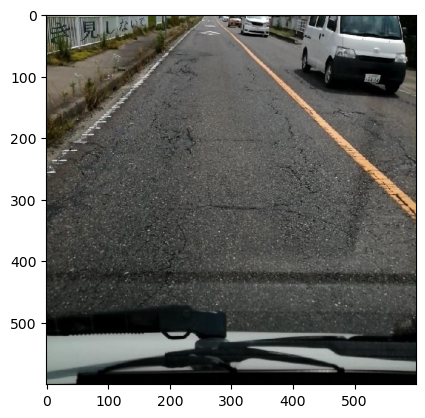

In [52]:
from ultralytics.utils.plotting import Annotator
import matplotlib.pyplot as plt
%matplotlib inline

test_img = cv2.imread(test_file_list[0])
img_src = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
results = model(img_src)

annotator = Annotator(img_src)
boxes = result.boxes
for box in boxes:
    cls = box.cls
    b = box.xyxy[0]
    annotator.box_label(b, model.names[int(cls)], color_dict[int(cls)])

plt.imshow(img_src)
plt.show()


0: 128x128 (no detections), 14.8ms
Speed: 0.8ms preprocess, 14.8ms inference, 0.3ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 (no detections), 17.3ms
Speed: 0.5ms preprocess, 17.3ms inference, 0.2ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 (no detections), 12.4ms
Speed: 0.5ms preprocess, 12.4ms inference, 0.2ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 (no detections), 11.2ms
Speed: 0.4ms preprocess, 11.2ms inference, 0.2ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 (no detections), 10.5ms
Speed: 0.5ms preprocess, 10.5ms inference, 0.2ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 (no detections), 13.7ms
Speed: 0.5ms preprocess, 13.7ms inference, 0.2ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 (no detections), 10.8ms
Speed: 0.4ms preprocess, 10.8ms inference, 0.2ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 (no detections), 12.2ms
Speed: 0.5ms preprocess, 12.2ms i

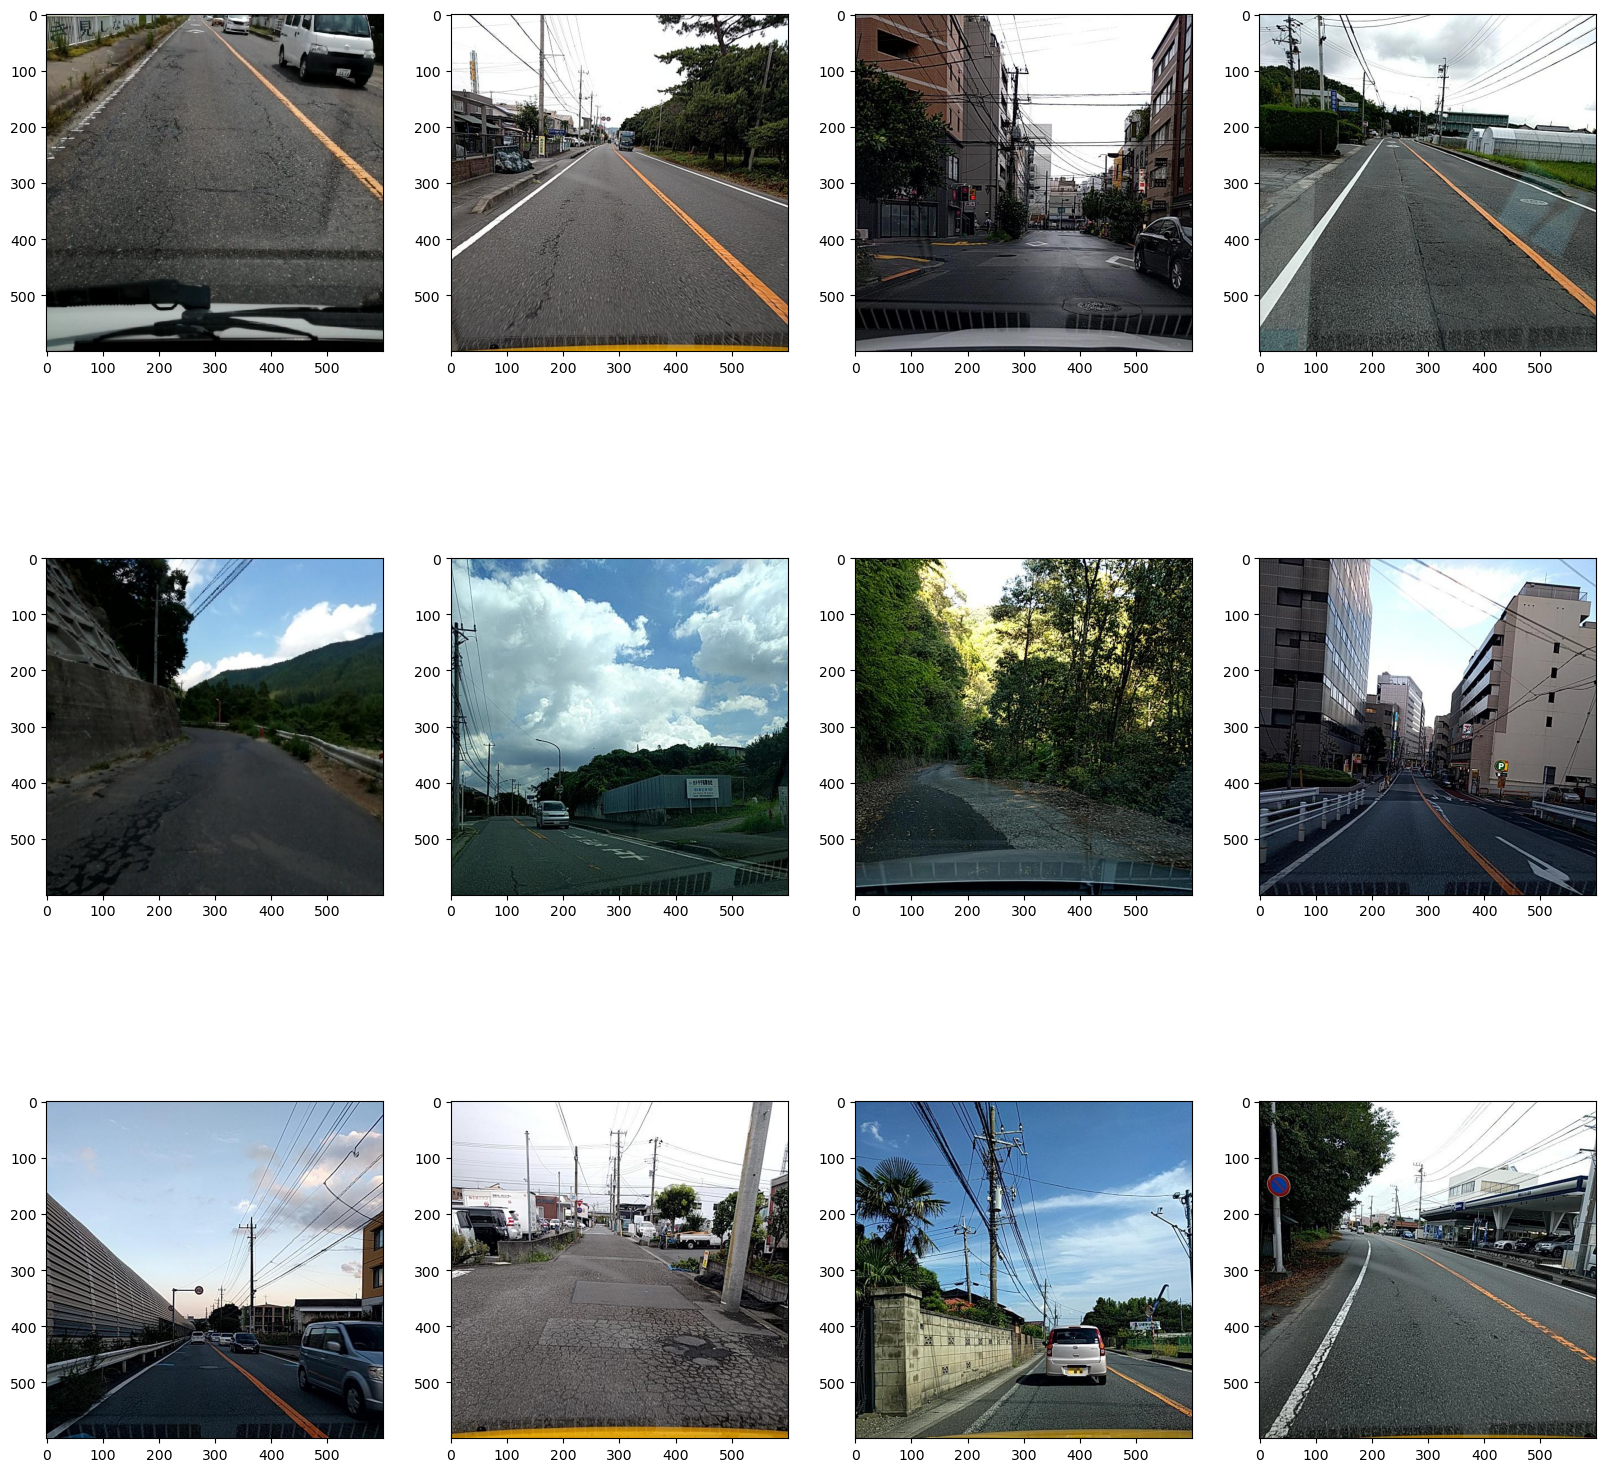

In [53]:
plt.figure(figsize=(20, 20))

for i in range(12):
    test_img = cv2.imread(test_file_list[i])
    img_src = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
    results = model(test_img)

    for reult in results:
        annotator = Annotator(img_src)
        boxes = result.boxes
        for box in boxes:
            cls = box.cls
            b = box.xyxy[0]
            annotator.box_label(b, model.names[int(cls)], color_dict[int(cls)])

    plt.subplot(3, 4, i+1)
    plt.imshow(img_src)